In [1]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Dense, Activation, add, Flatten, AveragePooling2D, concatenate
from keras.models import Model

from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import tensorflow as tf
from keras.utils import np_utils
import pandas as pd
import glob
from PIL import Image
import sys
import os
import matplotlib.pyplot as plt
import cv2

In [2]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [3]:
with_helmet_img = glob.glob('./new_helmet_augment/with_helmet_resize_128/with*.png')

In [4]:
without_helmet_img = glob.glob('./new_helmet_augment/without_helmet_resize_128/with*.png')

In [5]:
len(with_helmet_img)

10000

In [6]:
len(without_helmet_img)

10000

In [7]:
img_list = []

for i in range(len(with_helmet_img)):
    img = Image.open(with_helmet_img[i])
    img_list.append(img.resize((80,80)))

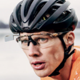

In [8]:
img_list[0]

In [9]:
img_list2 = []

for i in range(len(without_helmet_img)):
    img = Image.open(without_helmet_img[i])
    img_list2.append(img.resize((80,80)))

In [10]:
len(img_list)

10000

In [11]:
len(img_list2)

10000

In [12]:
with_helmet_img = img_list
without_helmet_img = img_list2

In [13]:
train_data = with_helmet_img + without_helmet_img

In [14]:
new_img_list = []

for i in range(len(train_data)):
    new_img_list.append(np.array(train_data[i]))

train_data = np.array(new_img_list)

In [15]:
len(train_data)

20000

In [16]:
train_data.shape

(20000, 80, 80, 3)

In [17]:
with_helmet_label = [1] * len(with_helmet_img)
without_helmet_label = [0] * len(without_helmet_img)

In [18]:
label_data = with_helmet_label + without_helmet_label

In [19]:
label_data = np.array(label_data)

In [20]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(train_data,label_data, random_state=7, test_size=0.2)

In [21]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [22]:
def inception(x, filters): 
    pre_layer = x # input layer / previous layer / 이전 레이어
    
    f1,f2,f3,f4 = filters #filter 수의 숫자

    # 1x1
    conv1 = Conv2D(f1, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)  #f1=64
    
    # 1x1 & 3x3  (functional API)
    conv2 = Conv2D(f4  , kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv2 = Conv2D(f2, kernel_size=(3,3), padding='same', activation='relu')(conv2)  #f2=128

    # 1x1 & 5x5
    conv3 = Conv2D(f4, kernel_size=(1,1), padding='same', activation='relu')(pre_layer)
    conv3 = Conv2D(f3, kernel_size=(5,5), padding='same', activation='relu')(conv3)  #f3=32
    
    # pooling & 1x1
    max_pool = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(pre_layer)
    max_pool = Conv2D(f4, kernel_size=(1,1), padding='same')(max_pool)

    # output = [None(batch_size), w(width),h(height),c(channel)], c 기준 concatenate (axis = -1 )
    # concatenate() >>  적층, axis=-1 >> channel 기준으로 적층하겠다는 의미 
    
    concat = concatenate([conv1, conv2, conv3, max_pool], axis=-1) # 위에 주석 참고하기
    
    return concat

In [ ]:
def googlenet():
    input_shape = x_train[0].shape    
    inputs = Input(shape=input_shape)

    # conv랑 batch 사이에 max pooling 들어가야 하나, cifar 데이터에선 크기 너무 줄어들어서 뺐음
    x = Conv2D(64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
    x = BatchNormalization()(x)
    x = Conv2D(192, kernel_size=(3,3), padding='same', activation='relu')(x)
    x = BatchNormalization()(x) 

    #inception (input, [#1x1conv, #3x3conv, #5x5conv, #1x1reduction] )


    # inception 3a
    x = inception(x,[64,128,32,32])
    # inception 3b
    x = inception(x,[128,192,96,64])
    x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

    # inception 4a
    x = inception(x,[192,208,48,64])
    aux1 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
    aux1 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux1)
    aux1 = Flatten()(aux1)
    aux1 = Dense(512, activation='relu')(aux1)  #512개 vector 
    aux1 = Dense(1, activation='sigmoid')(aux1) #cifar 10 data 10개 분류 

    # inception 4b
    x = inception(x,[160,224,64,64])


    # inception 4c
    x = inception(x,[128,256,64,64])
    # inception 4d
    x = inception(x,[112,288,64,64])
    aux2 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
    aux2 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux2)
    aux2 = Flatten()(aux2)
    aux2 = Dense(832, activation='relu')(aux2)
    aux2 = Dense(1, activation='sigmoid')(aux2)
    # loss 값이 얼마나 나왔는데 알기 위해 사용하는 기법


    # inception 4e
    x = inception(x,[256,320,128,128])


    # inception 5a
    x = inception(x,[256,320,128,128])
    # inception 5b
    x = inception(x,[384,384,128,128])
    x = AveragePooling2D(pool_size=(4,4), padding='valid')(x)
    x = Dropout(0.4)(x)
    x = Flatten()(x)

    outputs = Dense(1, activation='sigmoid')(x)
    model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])
    
    return model

In [23]:
input_shape = x_train[0].shape    
inputs = Input(shape=input_shape)

# conv랑 batch 사이에 max pooling 들어가야 하나, cifar 데이터에선 크기 너무 줄어들어서 뺐음
x = Conv2D(64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(inputs)
x = BatchNormalization()(x)
x = Conv2D(192, kernel_size=(3,3), padding='same', activation='relu')(x)
x = BatchNormalization()(x) 

#inception (input, [#1x1conv, #3x3conv, #5x5conv, #1x1reduction] )


# inception 3a
x = inception(x,[64,128,32,32])
# inception 3b
x = inception(x,[128,192,96,64])
x = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(x)

# inception 4a
x = inception(x,[192,208,48,64])
aux1 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
aux1 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux1)
aux1 = Flatten()(aux1)
aux1 = Dense(512, activation='relu')(aux1)  #512개 vector 
aux1 = Dense(1, activation='sigmoid')(aux1) #cifar 10 data 10개 분류 

# inception 4b
x = inception(x,[160,224,64,64])


# inception 4c
x = inception(x,[128,256,64,64])
# inception 4d
x = inception(x,[112,288,64,64])
aux2 = AveragePooling2D(pool_size=(5,5),strides = 3, padding='valid')(x)
aux2 = Conv2D(128, kernel_size=(1,1), padding='same', activation='relu')(aux2)
aux2 = Flatten()(aux2)
aux2 = Dense(832, activation='relu')(aux2)
aux2 = Dense(1, activation='sigmoid')(aux2)
# loss 값이 얼마나 나왔는데 알기 위해 사용하는 기법


# inception 4e
x = inception(x,[256,320,128,128])


# inception 5a
x = inception(x,[256,320,128,128])
# inception 5b
x = inception(x,[384,384,128,128])
x = AveragePooling2D(pool_size=(4,4), padding='valid')(x)
x = Dropout(0.4)(x)
x = Flatten()(x)

outputs = Dense(1, activation='sigmoid')(x)

In [24]:
model = Model(inputs=inputs, outputs=[aux1, aux2, outputs])

model.compile(optimizer='adam', loss='binary_crossentropy', loss_weights=[0.3,0.3,1.0], metrics=['accuracy'])

In [25]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 40, 40, 64)   9472        ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 40, 40, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 40, 40, 192)  110784      ['batch_normalization[0][0]']

In [26]:
# 모델 실행 환경 설정

# model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 최적화 구역 설정
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
  os.mkdir(MODEL_DIR)

modelpath = './model/goolgnet.hdf5'
checkpointer = ModelCheckpoint(filepath = modelpath, monitor='val_loss', verbose = 1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)

In [27]:
# 모델 실행

history = model.fit(x_train, y_train, validation_split=0.2, epochs=50, batch_size=32,
          verbose=0, callbacks=[early_stopping_callback, checkpointer])

# 테스트 정확도 출력
print('\n Test Dataset ACC : %.4f'%(model.evaluate(x_test,y_test)[-1]))


Epoch 1: val_loss improved from inf to 1.10371, saving model to ./model\goolgnet.hdf5

Epoch 2: val_loss did not improve from 1.10371

Epoch 3: val_loss improved from 1.10371 to 0.67329, saving model to ./model\goolgnet.hdf5

Epoch 4: val_loss improved from 0.67329 to 0.30374, saving model to ./model\goolgnet.hdf5

Epoch 5: val_loss did not improve from 0.30374

Epoch 6: val_loss improved from 0.30374 to 0.21275, saving model to ./model\goolgnet.hdf5

Epoch 7: val_loss did not improve from 0.21275

Epoch 8: val_loss did not improve from 0.21275

Epoch 9: val_loss did not improve from 0.21275

Epoch 10: val_loss did not improve from 0.21275

Epoch 11: val_loss did not improve from 0.21275

Epoch 12: val_loss improved from 0.21275 to 0.10051, saving model to ./model\goolgnet.hdf5

Epoch 13: val_loss did not improve from 0.10051

Epoch 14: val_loss improved from 0.10051 to 0.08601, saving model to ./model\goolgnet.hdf5

Epoch 15: val_loss did not improve from 0.08601

Epoch 16: val_loss 

In [42]:
model.evaluate(x_test, y_test)[-1]

125/125 [==============================] - 5s 39ms/step - loss: 0.0580 - dense_1_loss: 0.0281 - dense_3_loss: 0.0105 - dense_4_loss: 0.0194 - dense_1_accuracy: 0.9955 - dense_3_accuracy: 0.9962 - dense_4_accuracy: 0.9948


0.9947500228881836

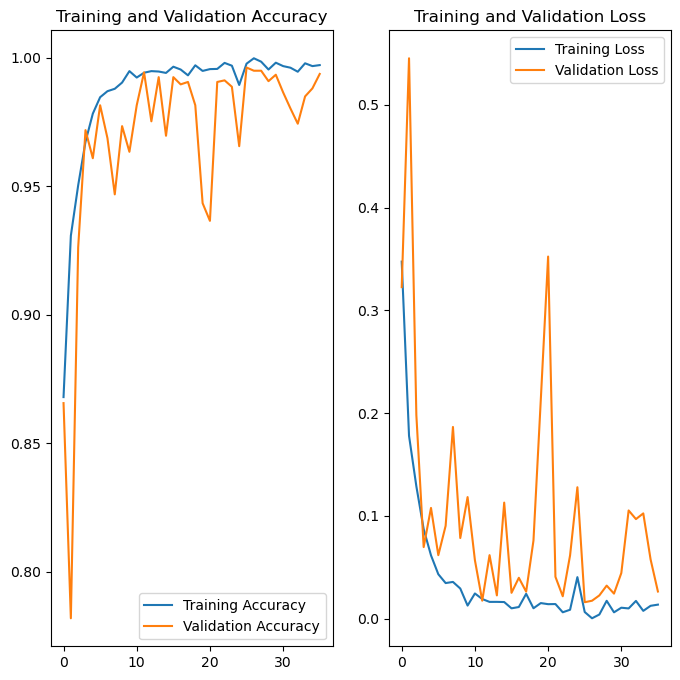

In [43]:
# 기본 모델 그림

import matplotlib.pyplot as plt

acc = history.history['dense_1_accuracy']
val_acc = history.history['val_dense_1_accuracy']

loss = history.history['dense_1_loss']
val_loss = history.history['val_dense_1_loss']

epochs_range = range(36)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from keras.models import load_model
model = load_model('./model/googlenet.hdf5')

In [59]:
print(round(model.evaluate(x_test, y_test)[-1],4))

125/125 [==============================] - 5s 40ms/step - loss: 0.0580 - dense_1_loss: 0.0281 - dense_3_loss: 0.0105 - dense_4_loss: 0.0194 - dense_1_accuracy: 0.9955 - dense_3_accuracy: 0.9962 - dense_4_accuracy: 0.9948


0.9948

In [133]:
sh_img = ['bb.png']
sh_img_1 = []
for i in range(len(sh_img)):
    img = Image.open(sh_img[i])
    sh_img_1.append(img.resize((100,100)))
    
img = np.array(sh_img_1[0])/255

img = img.reshape(1, 100, 100, -1)
img.shape

(1, 100, 100, 3)

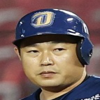

In [134]:
sh_img_1[0]

In [135]:
# 0.5 보다 크면 true, false로 반환하고 이걸 int32로 변환하면 0 혹은 1로 return 된다. 
# 결국 값이 0.5 보다 크면 1이고, 작게 되면 0으로 된다.

pred = (model.predict(img)[-1] > 0.5).astype("int32")

if pred == 0:
    print(pred, 'without_helmet')
else:
    print(pred, 'with_helmet')

1/1 [==============================] - 0s 18ms/step
[[1]] with_helmet
